In [1]:
# Error Calculator 2.2
# Python 3
# Author: Zein Jaafar

import openpyxl
import sympy as sp
import numpy as np
from sympy import sympify
from IPython.display import display

def partial_diff(f, var):
    """Creates a list of the partial derivatives of f with respect to the entries of
    the list var."""
    pds = []
    for i in var:
        pds += [f.diff(i)]
    return pds 

def eval_list(sym_list, variables, values):
    """Evaluates a list of sympy functions"""
    evaluated_list = []
    for function in sym_list:
        evaluated_list += [sp.lambdify(variables, function)(*values)]
    return evaluated_list

def extend_lists(dictionary):
    """Assuming a dictionary is passed whose values are all lists of length
    1 or x, changes the lists of legnth 1 to lists of length x by repeating the
    only entry"""
    
    length = 1
    
    # Finding x
    for i in dictionary:
        if len(dictionary[i]) != 1:
            length = len(dictionary[i])
            break
    
    # Extending lists of length 1
    for i in dictionary:
        if len(dictionary[i]) == 1:
            dictionary[i] = [dictionary[i][0], ]*length
            
    return dictionary

def error(f, var, all_values, all_errors):
    """var is a list of variables. num and err are evaluated column by column.
    num and err should be numpy arrays, preferably generated by num_gen. 
    Returns numpy matrix with two rows. First row contains evaluations of f and below
    each evaluation is the uncertainty (error) corresponding to that evaluation"""
    
    points = len(next (iter (dict.values(all_values))))
    final = np.zeros((2, points))
    
    pds = partial_diff(f, var)
    function = sp.lambdify(var, f)
    
    for n in range(points):
        values = np.array([all_values[key][n] for key in all_values])
        errors = np.array([all_errors[key+'_error'][n] for key in all_values])
        
        answer = function(*values)
        # Sympy is used at the end because the actual numbers are sympy objects
        # Due to using sympify to parse the inputs
        uncertainty = sp.sqrt(np.sum(np.power(eval_list(pds, var, values)*errors, 2)))
        
        final[:,n] = [answer, uncertainty]
    return final    
    

# simple error 
# uncertainty = (abs(answer-func(*(values + errors))) + abs(answer-(func(*(values - errors)))))/2



In [2]:
def dialogue(option, n=1):
    if option == 'welcome' and n:
        print("""Welcome to error calculator. I'm going to ask you for the name of your
variables, a function and some values. Then I will return you the value of your
function and its error. The results will be saved at the end""")
        
    elif option == 'variable_info' and n:
        print("""\nWe'll start by naming all our symbols/variables (here measured constants
and constants like the speed of light also count as symbols)""")
        
    elif option == 'function_info' and n:
        print("""Next I need a function. ^ can be used in place of **. You will be shown a preview before we 
move on so dont worry too much about mistakes""")
    
    elif option == 'data_info' and n:
        print("""\nGreat! Now we're nearly done. Now you just need to tell me the value
of your variables and the errors on them. You can also enter just one number 
if the variables value doesnt change. If you're asked for the error on one
of your constants just type 0.""")
    
    elif option == 'excel_info' and n:
        print("""\nYou've chosen to import data from an excel spreadsheet. Firstly make
sure the spreadsheet is in the same folder as this file and that you've saved 
it so I dont read old values. Then I'll ask you for the name of your
spreadsheet and then the rows and columns to import. Lets begin!\n""")
        
    elif option == 'excel_info2' and n:
        print("""Great. Next I'll ask you where the data is for each variable. For 
example if my x values were in column C rows 2-5 I'd type C2:C5\n""")
        
    elif option == 'ending' and n:
        print("""\nFinished! The value of the function is above and its error is below. 
These results are stored in a variable named ans_err\n""")     
        
    else:
        pass


In [3]:
values = {}
errors = {}

# Uncomment the below line
#variables = list(values.keys())

Would you like to enable help? Help is 
        recommended for your first time. Type y/n
n
Please type in your variable names seperated by commas 
Ip, Is, cIp, cIs
Your variables are: ['Ip', 'Is', 'cIp', 'cIs'] 
Does this look correct? If so press enter, otherwise type n

Please type out your function here.
1 - (Ip/Is)*(cIs/cIp)


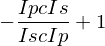


Does this look correct? If so press enter, otherwise type n

Would you like to read your data from an excel spreadsheet 
         instead of inputting it by hand? Type y/n.
y
Please input the file name of your workbook (without the .xlsx extension)
Ram Data 6

Data can be automatically loaded if the excel file has columns with the same names as your variables.
            Type anything to use this option or press enter to specify the coordinates manually.

Please enter the co-ordinates for the value(s) of Ip
E4:E59
Please enter the co-ordinates of the error(s) on Ip
F4:F59
Please enter the co-ordinates for the value(s) of Is
C4:C59
Please enter the co-ordinates of the error(s) on Is
D4:D59
Please enter the co-ordinates for the value(s) of cIp
N4:N59
Please enter the co-ordinates of the error(s) on cIp
O4:O59
Please enter the co-ordinates for the value(s) of cIs
L4:L59
Please enter the co-ordinates of the error(s) on cIs
M4:M59

Would you like to change any variable values or errors be

In [4]:
calculating = 1
iteration = 0
sp.init_printing(use_latex=True)

while calculating:
    if calculating == 1:
        values = {}
        errors = {}

        iteration += 1
        modifier = '0'

        # Turning help on or off

        info = input("""Would you like to enable help? Help is 
        recommended for your first time. Type y/n\n""").replace(" ", "").lower()
        if info in ['n', '']:
            info = 0

        # Finding out what variables to use

        dialogue('welcome', info)
        dialogue('variable_info', info)
        n = 1
        while n:
            variables = input("Please type in your variable names seperated by commas \n")
            # Parsing the input string with regular expressions to find the variables
            variables = variables.split(",")
            variables = [string.strip() for string in variables]

            print("Your variables are:", variables, "\nDoes this look correct? If so press enter, otherwise type n")
            n = input()

        # Getting a function from the user

        dialogue('function_info', info)

        n = 1
        while n:
            n = 1
            function = input("Please type out your function here.\n")

            # Declaring all symbols using the variable names found previously, then attmepting to create a sympy function.
            # In cases where strange variable names like and are used an error arises and the variable is renamed and0.
            local_dict = {}
            for string in variables:
                local_dict[string] = sp.Symbol(string)

            try:
                function = sympify(function, locals=local_dict)
            except:
                print("One of your variables was causing problems so I added 0's to the end of potential offenders")
                local_dict = {}
                identifier = '_'
                amount = len(variables)-1
                ord_vars = sorted(variables, key=len, reverse=True)

                flag = True

                while flag:
                    if identifier in function:
                        identifier += identifier
                    else:
                        flag = False

                for k in range(amount+1):
                    string = ord_vars[k]
                    if len(string) > 1:
                        function = function.replace(string, identifier + str(k))

                for k in range(amount+1):
                    string = ord_vars[amount-k]
                    if len(string) > 1:
                        function = function.replace(identifier + str(amount-k), string + modifier)
                        ord_vars[amount-k] = string + modifier
                        local_dict[string + modifier] = sp.Symbol(string + modifier)

                variables = ord_vars
                function = sympify(function, locals=local_dict)

            # If any variables are used in the function given that were not declared earlier this error is raised..
            for var in function.free_symbols:
                    if var not in list(local_dict.values()):
                        print("""An error occured, the variable '{}' in your function was not declared earlier 
                        but it was used in the function. You will have to re-write the function.""".format(var))
                        n = 2
                        break

            if n != 2:
                display(function)
                print("\nDoes this look correct? If so press enter, otherwise type n")
                n = input()

        from_excel = input("""Would you like to read your data from an excel spreadsheet 
         instead of inputting it by hand? Type y/n.\n""").replace(" ", "").lower()

        # Inputting the data manually

        if from_excel in ['n', '']:
            dialogue('data_info', info)

            for i in range(len(variables)):
                n = 1
                while n:
                    var = variables[i]
                    print("Please type in the value(s) for '{}' seperated by commas".format(var))
                    var_vals = input()
                    var_vals = var_vals.split(',')
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                        n = 0
                    except:
                        print("There was a problem with your input, try that again.")

                values[var] = var_vals

                n = 1
                while n:
                    print("\nPlease type in the error(s) on", var)
                    var_vals = input()
                    var_vals = var_vals.split(',')
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                        n = 0
                    except:
                        print("There was a problem with your input, try that again.")

                errors[var + '_error'] = var_vals

        # Obtaining the data from excel

        else:
            print("Please input the file name of your workbook (without the .xlsx extension)")
            filename = input()
            wb = openpyxl.load_workbook(filename+'.xlsx')
            sheet = wb.active

            print("""\nData can be automatically loaded if the excel file has columns with the same names as your variables.
            Type anything to use this option or press enter to specify the coordinates manually.""")
            auto = input()

            if auto:
                print("""\nPlease specify how error columns are named. For example if there is a column named 'x' and the errors
            on x are in a column called 'x_error' then type in '_error'.""")
                err_modifier = input()
                print("Is this a prefix or suffix. Type p or s.")
                pre_suf = input()
                
                # Creating list of heading names
                if pre_suf == 's':
                    err_names = [variables[i]+err_modifier for i in range(len(variables))]
                else:
                    err_names = [err_modifier+variables[i] for i in range(len(variables))]

                # Finding sheet dimensions
                min_row = sheet.min_row
                max_row = sheet.max_row
                min_col = sheet.min_column
                max_col = sheet.max_column

                # Iterating through headings to see if any match given variables
                
                for col in range(min_col, max_col):
                    if sheet.cell(row=min_row, column=col).value in variables:
                        var = sheet.cell(row=min_row, column=col).value
                        values[var] = []
                        
                        # Adding all values in said column to database
                        
                        for row in range(min_row+1, max_row+1):
                            values[var] += [sheet.cell(row=row, column=col).value]

                    if sheet.cell(row=min_row, column=col).value in err_names:
                        
                        # Removing prefix/suffix and adding _error suffix so dictionary entries are all the same
                        if pre_suf == 's':
                            var = sheet.cell(row=min_row, column=col).value
                            var = var[0:len(err_modifier)]
                        else:
                            var = sheet.cell(row=min_row, column=col).value
                            var = var[len(err_modifier):-1] + var[-1]
                            
                        var += '_error'
                        errors[var] = []
                        for row in range(min_row+1, max_row+1):
                            errors[var] += [sheet.cell(row=row, column=col).value]
            
            else:
                for var in variables:
                    print("Please enter the co-ordinates for the value(s) of", var)
                    indexes = input().upper().split(':')
                    values[var] = []
                    for j in sheet[indexes[0]:indexes[1]]:
                        values[var] += [j[0].value]    

                    print("Please enter the co-ordinates of the error(s) on", var)
                    indexes = input().upper().split(':')
                    errors[var+'_error'] = []
                    for j in sheet[indexes[0]:indexes[1]]:
                        errors[var+'_error'] += [j[0].value]
                        
        # Editing Data
        
        m = 1
        while m:
            print("""\nWould you like to change any variable values or errors before final computation. Press enter to finish
            or type a variable name to view it and change its values. To simply view all data type view.""")
            choice = input()
            if not choice:
                m = 0
            elif choice.lower() == 'view':
                print("Values are \n{}\n and errors are \n{}".format(values, errors))
            elif choice in variables:
                n = 1
                while n:
                    n = 1
                    var = choice
                    print("Please type in the value(s) for '{}' seperated by commas".format(var))
                    var_vals = input()
                    var_vals = var_vals.split(",")
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                    except:
                        print("There was a problem with your input, try that again.")
                        n = 2

                    if n != 2:
                        print(var_vals)
                        n = input("Are these your values. If so press enter to continue. Otherwise type n.")

                values[var] = var_vals

                n = 1
                while n:
                    n = 1
                    print("\nPlease type in the error(s) on '{}' seperated by commas".format(var))
                    var_vals = input()
                    var_vals = var_vals.split(",")
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                    except:
                        print("There was a problem with your input, try that again.")
                        n = 2

                    if n != 2:
                        print(var_vals)
                        n = input("Are these your values. If so press enter to continue. Otherwise type n.")

                errors[var + '_error'] = var_vals

            else:
                m = 0
                    

        # Putting the data in the right format and calculating error

        values = extend_lists(values)
        errors = extend_lists(errors)
        ans_err = error(function, variables, values, errors)
        dialogue('ending', info)
        print(ans_err)

        print("Would you like to write all your data into an excel spreasheet? Type y/n")
        save = input().replace(" ", "").lower()

        if save in ['y', 'yes']:
            wb = openpyxl.Workbook()
            sheet = wb.active
            points = len(next (iter (dict.values(values))))

            # Saving input data
            
            for i in range(0, len(variables)*2, 2):
                var = variables[int(i/2)]
                # Headings
                sheet.cell(row=1, column=i+1).value = var
                sheet.cell(row=1, column=i+2).value = 'Δ' + var
                # Data
                for j in range(points):
                    sheet.cell(row=j+2, column=i+1).value = float(values[var][j])
                    sheet.cell(row=j+2, column=i+2).value = float(errors[var+'_error'][j])

            # Saving evaluations
            sheet.cell(row=1, column=(len(variables)*2 + 2)).value = "f(variables)"
            sheet.cell(row=1, column=(len(variables)*2 + 3)).value = "Δf(variables)"
            for i in range(ans_err.shape[1]):
                sheet.cell(row=i+2, column=(len(variables)*2 + 2)).value = ans_err[0, i]
                sheet.cell(row=i+2, column=(len(variables)*2 + 3)).value = ans_err[1, i]
            savename = input("Type in a name for your file.").lower()
            savename += ".xlsx"
            wb.save(savename)

        # Options for quitting/starting a new calculation    
          
        print("Would you like to calculate another error? Type yes or press enter to quit")
        calculating = input().lower()
        if calculating not in ['n', 'no', '']:
            print("""Would you like to load any data used here in the next calculation. You will
             be given the option to modify (to a degree) the data you load and add new data.
             Please type in the number corresponding to your choice then press enter.
            1: Load nothing
            2: Load same variables
            3: Load same variables and function
            4: Load same variables and their values/errors.
            """)
            try:
                calculating = int(input())
            except:
                print("Please enter a valid input")
                calculating = int(input())
        else:
            calculating = 0
        
        
########## New Calculation with saved data

    else:
        iteration += 1

        # Finding out what variables to use
        if calculating != 3:
            new_variables = []
            print("""The following variables were loaded.\n{}\n You can press enter to continue or type in new variables to add (seperated by commas).
            Furthermore if you type an existing variables name it will be deleted""".format(variables))
            
            # Parsing the input string with regular expressions to find the variables
            new_delete = input()
            new_delete = new_delete.split(",")
            new_delete = [string.strip() for string in new_delete]
            
            for var in new_delete:
                if var in variables:
                    variables.remove(var)
                    del values[var]
                    del errors[var+'_error']
                elif var:
                    variables += [var]
                    new_variables += [var]
                    
        else:
            new_variables = variables
            
        if calculating != 4:
            print("Resetting variable data")
            values = {}
            errors = {}
            new_variables = variables

        # Getting a function from the user

        n = 1
        while n and calculating != 3:
            n = 1
            function = input("Please type out your function here.\n")

            # Declaring all symbols using the variable names found previously, then attmepting to create a sympy function.
            # In cases where strange variable names like and are used an error arises and the variable is renamed and0.
            local_dict = {}
            for string in variables:
                local_dict[string] = sp.Symbol(string)

            try:
                function = sympify(function, locals=local_dict)
            except:
                print("One of your variables was causing problems so I added 0's to the end of potential offenders")
                local_dict = {}
                identifier = '_'
                amount = len(variables)-1
                ord_vars = sorted(variables, key=len, reverse=True)

                flag = True

                while flag:
                    if identifier in function:
                        identifier += identifier
                    else:
                        flag = False

                for k in range(amount+1):
                    string = ord_vars[k]
                    if len(string) > 1:
                        function = function.replace(string, identifier + str(k))

                for k in range(amount+1):
                    string = ord_vars[amount-k]
                    if len(string) > 1:
                        function = function.replace(identifier + str(amount-k), string + modifier)
                        ord_vars[amount-k] = string + modifier
                        local_dict[string + modifier] = sp.Symbol(string + modifier)

                variables = ord_vars
                function = sympify(function, locals=local_dict)

            # If any variables are used in the function given that were not declared earlier this error is raised..
            for var in function.free_symbols:
                    if var not in list(local_dict.values()):
                        print("""An error occured, the variable '{}' in your function was not declared earlier 
                        but it was used in the function. You will have to re-write the function.""".format(var))
                        n = 2
                        break

            if n != 2:
                display(function)
                print("\nDoes this look correct? If so press enter, otherwise type n")
                n = input()

           
        # If new data is needed the data collection section below will run
        
        if new_variables:
            from_excel = input("""Would you like to read your data from an excel spreadsheet 
             instead of inputting it by hand? Type y/n.\n""").replace(" ", "").lower()

            # Inputting the data manually


            if from_excel in ['n', '']:

                for i in range(len(new_variables)):
                    n = 1
                    while n:
                        var = new_variables[i]
                        print("Please type in the value(s) for", var)
                        var_vals = input()
                        var_vals = var_vals.split(",")
                        var_vals = [string.strip() for string in var_vals]


                        try:
                            var_vals = sympify(var_vals)
                            n = 0
                        except:
                            print("There was a problem with your input, try that again.")

                    values[var] = var_vals

                    n = 1
                    while n:
                        print("\nPlease type in the error(s) on", var)
                        var_vals = input()
                        var_vals = var_vals.split(",")
                        var_vals = [string.strip() for string in var_vals]

                        try:
                            var_vals = sympify(var_vals)
                            n = 0
                        except:
                            print("There was a problem with your input, try that again.")

                    errors[var + '_error'] = var_vals

            # Obtaining the data from excel

            else:
                print("Please input the file name of your workbook (without the .xlsx extension)")
                filename = input()
                wb = openpyxl.load_workbook(filename+'.xlsx')
                sheet = wb.active

                print("""\nData can be automatically loaded if the excel file has columns with the same names as your variables.
                Type anything to use this option or press enter to specify the coordinates manually.""")
                auto = input()

                if auto:
                    print("""\nPlease specify how error columns are named. For example if there is a column named 'x' and the errors
                on x are in a column called 'x_error' then type in '_error'.""")
                    err_modifier = input()
                    print("Is this a prefix or suffix. Type p or s.")
                    pre_suf = input()

                    # Creating list of heading names
                    if pre_suf == 's':
                        err_names = [new_variables[i]+err_modifier for i in range(len(new_variables))]
                    else:
                        err_names = [err_modifier+new_variables[i] for i in range(len(new_variables))]

                    # Finding sheet dimensions
                    min_row = sheet.min_row
                    max_row = sheet.max_row
                    min_col = sheet.min_column
                    max_col = sheet.max_column

                    # Iterating through headings to see if any match given variables

                    for col in range(min_col, max_col):
                        if sheet.cell(row=min_row, column=col).value in new_variables:
                            var = sheet.cell(row=min_row, column=col).value
                            values[var] = []

                            # Adding all values in said column to database

                            for row in range(min_row+1, max_row+1):
                                values[var] += [sheet.cell(row=row, column=col).value]

                        if sheet.cell(row=min_row, column=col).value in err_names:

                            # Removing prefix/suffix and adding _error suffix so dictionary entries are all the same
                            if pre_suf == 's':
                                var = sheet.cell(row=min_row, column=col).value
                                var = var[0:len(err_modifier)]
                            else:
                                var = sheet.cell(row=min_row, column=col).value
                                var = var[len(err_modifier):-1] + var[-1]

                            var += '_error'
                            errors[var] = []
                            for row in range(min_row+1, max_row+1):
                                errors[var] += [sheet.cell(row=row, column=col).value]

                else:
                    for var in new_variables:
                        print("Please enter the co-ordinates for the value(s) of", var)
                        indexes = input().upper().split(':')
                        values[var] = []
                        for j in sheet[indexes[0]:indexes[1]]:
                            values[var] += [j[0].value]    

                        print("Please enter the co-ordinates of the error(s) on", var)
                        indexes = input().upper().split(':')
                        errors[var+'_error'] = []
                        for j in sheet[indexes[0]:indexes[1]]:
                            errors[var+'_error'] += [j[0].value]


            # Putting the data in the right format and calculating error

            values = extend_lists(values)
            errors = extend_lists(errors)

        # Editing Data
        
        m = 1
        while m:
            print("""\nWould you like to change any variable values or errors before final computation. Press enter to finish
            or type a variable name to view it and change its values. To simply view all data type view.""")
            choice = input()
            if not choice:
                m = 0
            elif choice.lower() == 'view':
                print("Values are \n{}\n and errors are \n{}".format(values, errors))
            elif choice in variables:
                n = 1
                while n:
                    n = 1
                    var = choice
                    print("Please type in the value(s) for '{}' seperated by commas".format(var))
                    var_vals = input()
                    var_vals = var_vals.split(",")
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                    except:
                        print("There was a problem with your input, try that again.")
                        n = 2

                    if n != 2:
                        print(var_vals)
                        n = input("Are these your values. If so press enter to continue. Otherwise type n.")

                values[var] = var_vals

                n = 1
                while n:
                    n = 1
                    print("\nPlease type in the error(s) on '{}' seperated by commas".format(var))
                    var_vals = input()
                    var_vals = var_vals.split(",")
                    var_vals = [string.strip() for string in var_vals]

                    try:
                        var_vals = sympify(var_vals)
                    except:
                        print("There was a problem with your input, try that again.")
                        n = 2

                    if n != 2:
                        print(var_vals)
                        n = input("Are these your values. If so press enter to continue. Otherwise type n.")

                errors[var + '_error'] = var_vals

            else:
                m = 0
                
        # Computing values and errors
        
        ans_err = error(function, variables, values, errors)
        print(ans_err)

        print("Would you like to write all your data into an excel spreasheet? Type y/n")
        save = input().replace(" ", "").lower()

        if save in ['y', 'yes']:
            wb = openpyxl.Workbook()
            sheet = wb.active
            points = len(next (iter (dict.values(values))))

            # Saving input data
            
            for i in range(0, len(variables)*2, 2):
                var = variables[int(i/2)]
                # Headings
                sheet.cell(row=1, column=i+1).value = var
                sheet.cell(row=1, column=i+2).value = 'Δ' + var
                # Data
                for j in range(points):
                    sheet.cell(row=j+2, column=i+1).value = float(values[var][j])
                    sheet.cell(row=j+2, column=i+2).value = float(errors[var+'_error'][j])

            # Saving evaluations
            
            sheet.cell(row=1, column=(len(variables)*2 + 2)).value = "f(variables)"
            sheet.cell(row=1, column=(len(variables)*2 + 3)).value = "Δf(variables)"
            for i in range(ans_err.shape[1]):
                sheet.cell(row=i+2, column=(len(variables)*2 + 2)).value = ans_err[0, i]
                sheet.cell(row=i+2, column=(len(variables)*2 + 3)).value = ans_err[1, i]
            savename = input("Type in a name for your file.\n").lower()
            savename += ".xlsx"
            wb.save(savename)
        
        print("Would you like to calculate another error? Type yes or press enter to quit")
        calculating = input().lower()
        if calculating not in ['n', 'no', '']:
            print("""Would you like to load any data used here in the next calculation. You will
             be given the option to modify (to a degree) the data you load and add new data.
             Please type in the number corresponding to your choice then press enter.
            1: Load nothing
            2: Load same variables
            3: Load same variables and function
            4: Load same variables and their values/errors.
            """)
            try:
                calculating = int(input())
            except:
                print("Please enter a valid input")
                calculating = int(input())
        else:
            calculating = 0
            